In [92]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
!wget -O bronze.zip http://grail.cs.washington.edu/projects/photomontage/data/bronze.zip && unzip -o bronze.zip

In [94]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

def h_color(a, interpolation=None):
  s = [a.shape[0] * 2, a.shape[1] * 2]
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap="gray", interpolation=interpolation)

css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td { 
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""

def h(s):
   return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

def h_color_3d(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.show()

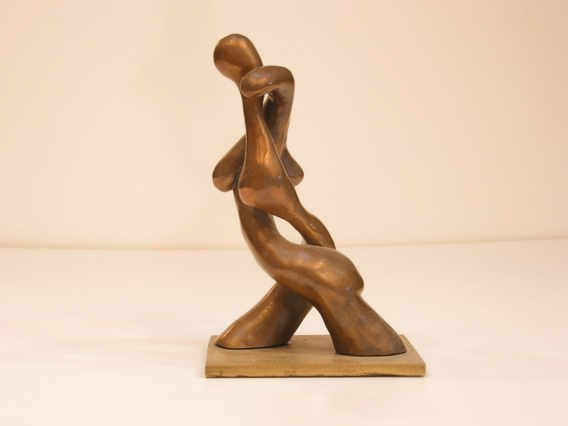

In [95]:
files = [
    '/content/IMG_3083.JPG',
    '/content/IMG_3084.JPG',
    '/content/IMG_3085.JPG',
    '/content/IMG_3086.JPG',
    '/content/IMG_3087.JPG',
    '/content/IMG_3088.JPG',
    '/content/IMG_3089.JPG',
    '/content/IMG_3090.JPG',
    '/content/IMG_3091.JPG',
    '/content/IMG_3092.JPG',
    '/content/IMG_3093.JPG',
    '/content/IMG_3094.JPG',
    '/content/IMG_3095.JPG',
    '/content/IMG_3096.JPG',
    '/content/IMG_3097.JPG',
]

figures = [cv2.imread(f, 1) for f in files]
flatten_imgs = [i.flatten() for i in figures]


avg_img = np.zeros(len(flatten_imgs[0]))
for i in flatten_imgs:
  avg_img = np.add(avg_img, i)
avg_img /= len(figures)

avg_img = np.reshape(np.around(avg_img), figures[0].shape)

imshow(avg_img)

img_float32 = np.float32(avg_img)
img_grayscale = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)

In [70]:
img_grayscale2 = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)
a = np.mean(img_grayscale2)

mask = img_grayscale>a-15

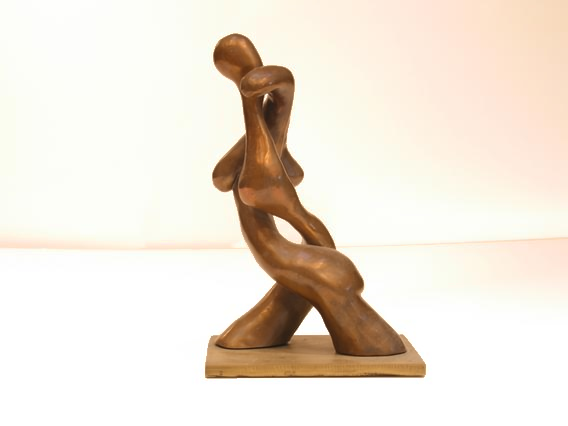

In [26]:
from copy import deepcopy

def modify_field_brightness(x, i, j, image, images, threshold):
  if x == True:
    tmp = np.argsort(np.array([np.mean(k[i][j]) for k in images]))
    image[i][j] = images[tmp[threshold]][i][j]

for i_idx, i in enumerate(mask):
  for j_idx, j in enumerate(i):
    modify_field_brightness(j, i_idx, j_idx, avg_img, figures, 13)

imshow(avg_img)

In [ ]:
a_img = deepcopy(avg_img)

def get_mask_object_brightness(image, mask):
  matrix = np.empty((0,3))
  #matrix = np.sum((image[row_idx][col_idx] for col_idx, j in enumerate(i) if mask[row_idx][col_idx] == False) for row_idx, i in enumerate(mask))
  for row_idx, i in enumerate(mask):
    for col_idx, j in enumerate(i):
      if mask[row_idx][col_idx] == False:
        matrix = np.vstack([matrix, image[row_idx][col_idx]])
  return np.mean(matrix)

def get_the_brightest_points(image, mask, threshold):
  matrix = np.full((image.shape[0], image.shape[1]), False)
  mask_brightness = get_mask_object_brightness(image, mask)

  for row_idx, j in enumerate(image):
    for col_idx, k in enumerate(j):
      if mask[row_idx][col_idx]==False:
        if np.mean(image[row_idx][col_idx]) > 160:
          matrix[row_idx][col_idx] = True

  return matrix

for k in figures:
  matrix = get_the_brightest_points(k, mask, 1.6)

  for row_idx, i in enumerate(matrix):
    for col_idx, j in enumerate(i):
      if matrix[row_idx][col_idx] == True:
        a_img[row_idx][col_idx] = k[row_idx][col_idx]

imshow(a_img*avg_img)

# struct = np.ones([2, 2], np.uint8)
# imshow(cv2.erode(imaaa.astype('uint8'), struct))
# imshow(cv2.morphologyEx(imaaa.astype('uint8'), cv2.MORPH_OPEN, struct))

In [41]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask,(s[0]//2, s[1]//2), s[0]//div, 1, -1)

def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum

def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


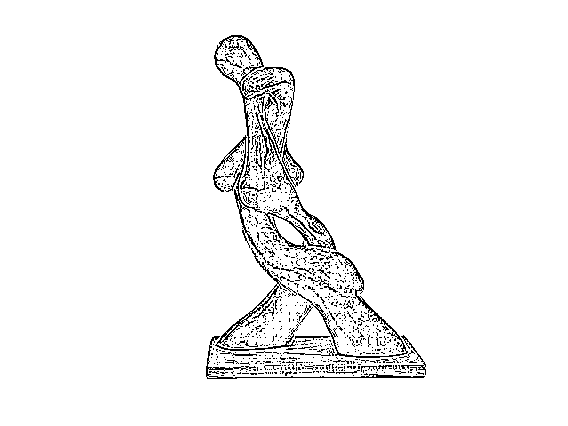

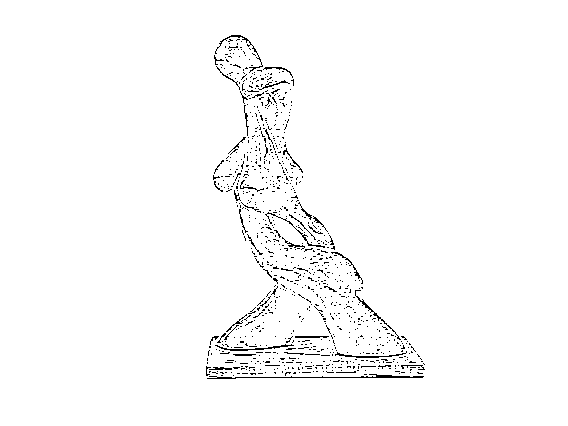

In [85]:
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

# intensity

f_lap_shift, f_lap_mag = fft(laplacian, (426, 568))
fshift, spectrum = fft(img_grayscale)
img_i = ifft(fshift * f_lap_shift)

img_i = np.array([[0 if j > 4 else 255 for j in i] for i in img_i])

#imshow(img_i)

struct = np.ones([1, 1], np.uint8)

#imshow(cv2.erode(img_i.astype('uint8'), struct))

img_space_close = cv2.morphologyEx(img_i.astype('uint8'), cv2.MORPH_OPEN, struct)
img_space_open = cv2.morphologyEx(img_space_close, cv2.MORPH_OPEN, struct)
img_space_close2 = cv2.morphologyEx(img_space_open, cv2.MORPH_CLOSE, struct)

img_space_close = cv2.morphologyEx(img_space_close.astype('uint8'), cv2.MORPH_CLOSE, struct)

x = cv2.bilateralFilter(img_space_close, 9,75,75)
x_mean = np.mean(x)
x = np.array([[255 if j > x_mean else 0 for j in i] for i in x])
x = np.array([[x[row_idx][col_idx] if j == False else 255 for col_idx, j in enumerate(i)] for row_idx, i in enumerate(mask)])

imshow(x)

for i in x:
  for j in range(len(i)):
    if j!=len(i)-1 and i[j] != i[j+1]:
      i[j] = 255

imshow(x)

#imshow(x)

# def conv(f, g):
#   pad_v = (g.shape[0] - 1) // 2
#   pad_h = (g.shape[1] - 1) // 2

#   fb = cv2.copyMakeBorder(f, pad_v, pad_v, pad_h, pad_h, cv2.BORDER_CONSTANT, 0)

#   itr_col = fb.shape[1] - g.shape[1] + 1
#   itr_row = fb.shape[0] - g.shape[0] + 1  
#   fg_cv = np.empty((0, f.shape[1]), np.uint8)

#   for i in range(itr_row):
#     fg_a = np.array([], np.uint8)
#     for j in range(itr_col):
#       s = 0
#       for idx1, a in enumerate(g):
#         for idx2, b in enumerate(a):
#           s += b * fb[idx1 + i][idx2 + j]

#       if s/9 > 160:
#         fg_a = np.append(fg_a, 255)
#       else:
#         fg_a = np.append(fg_a, 0)

#     fg_cv = np.vstack([fg_cv, fg_a])

#   return fg_cv

# struct = np.ones([3, 3], np.uint8)
# mm = conv(img_space_close, struct)

# imshow(mm)